In [133]:
import numpy as np
import qiskit
assert qiskit.__version__ == '1.4.1'    
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.primitives import Sampler, Estimator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city

# Exercise 1:
control if the sequence is correct:

<div style="text-align: center;">
<img src="es1.png" width=>
</div>

* $\ket{00} \rarr^{I \otimes I} \ket{00} \rarr^{H \otimes I} \frac{\ket{0}+\ket{1}}{\sqrt{2}} \otimes \ket{0} = \frac{\ket{00}+\ket{10}}{\sqrt{2}} \rarr^{CNOT} \frac{\ket{00}+\ket{11}}{\sqrt{2}}$


* $\ket{00} \rarr^{I \otimes X} \ket{01} \rarr^{H \otimes I} \frac{\ket{0}+\ket{1}}{\sqrt{2}} \otimes \ket{1} = \frac{\ket{01}+\ket{11}}{\sqrt{2}} \rarr^{CNOT} \frac{\ket{01}+\ket{10}}{\sqrt{2}}$


* $\ket{00} \rarr^{Z \otimes I} \ket{00} \rarr^{H \otimes I} \frac{\ket{0}+\ket{1}}{\sqrt{2}} \otimes \ket{0} = \frac{\ket{00}+\ket{10}}{\sqrt{2}} \rarr^{CNOT} \frac{\ket{00}+\ket{11}}{\sqrt{2}}$

* $\ket{00} \rarr^{I \otimes X} \ket{01} \rarr^{Z \otimes I} \ket{01} \rarr^{H \otimes I} \frac{\ket{0}+\ket{1}}{\sqrt{2}} \otimes \ket{1} = \frac{\ket{01}+\ket{11}}{\sqrt{2}} \rarr^{CNOT} \frac{\ket{01}+\ket{10}}{\sqrt{2}}$


Build the circuit

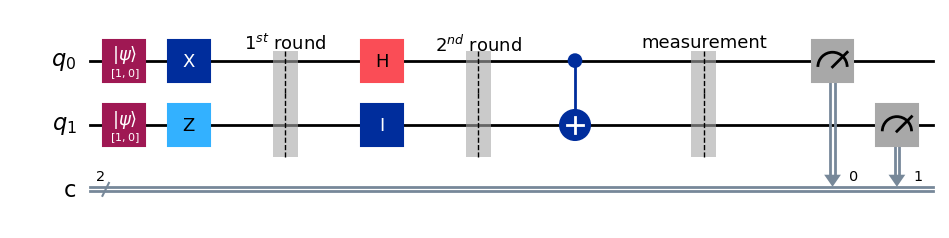

In [134]:
def build_circuit(a:int, b:int) -> QuantumCircuit:
    qr = QuantumRegister(2, name='q')
    cr = ClassicalRegister(2, name='c')
    qc = QuantumCircuit(qr, cr)

    init = [1, 0]
    qc.initialize(init, 0)
    qc.initialize(init, 1)

    if a == 1:
        qc.x(0)
    else:
        qc.id(0)
    
    if b == 1:
        qc.z(1)
    else:
        qc.id(1)
    
    qc.barrier(label='$1^{st}$ round')

    qc.h(0)
    qc.id(1)

    qc.barrier(label='$2^{nd}$ round')

    qc.cx(0, 1)

    qc.barrier(label='measurement')

    qc.measure(0, 0)
    qc.measure(1, 1)

    return qc

build_circuit(1, 1).draw(output='mpl')

Measurements through simulations

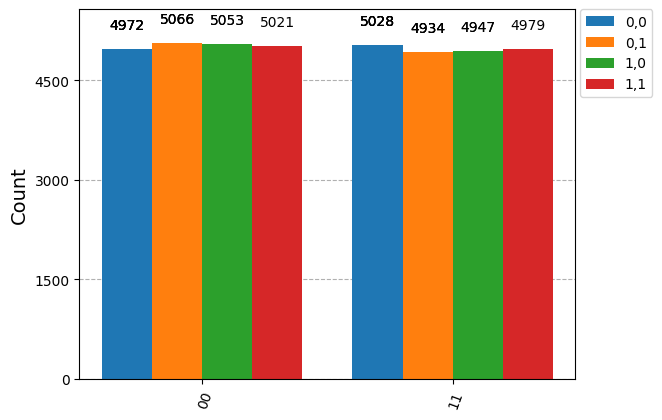

In [135]:
sequences = [(a, b) for a in [0, 1] for b in [0, 1]]
counts = []

for a, b in sequences:
    qc = build_circuit(a, b)
    sim = AerSimulator(method='statevector')
    result = sim.run(qc, shots=10000).result()
    counts.append(result.get_counts())

plot_histogram(counts, legend=[f'{a},{b}' for a, b in sequences])
# plot_histogram(counts[0])

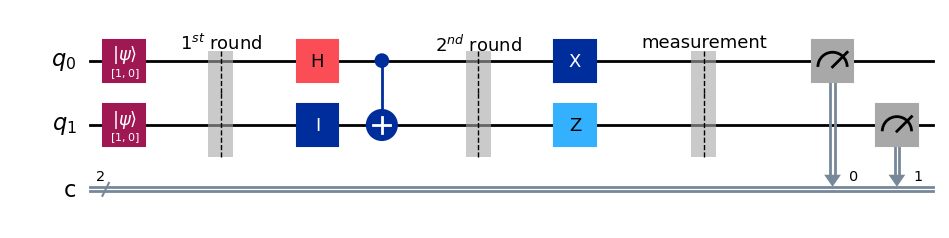

In [136]:
def build_circuit(a:int, b:int) -> QuantumCircuit:
    qr = QuantumRegister(2, name='q')
    cr = ClassicalRegister(2, name='c')
    qc = QuantumCircuit(qr, cr)

    init = [1, 0]
    qc.initialize(init, 0)
    qc.initialize(init, 1)

    
    qc.barrier(label='$1^{st}$ round')

    qc.h(0)
    qc.id(1)
    qc.cx(0, 1)

    qc.barrier(label='$2^{nd}$ round')

    if a == 1:
        qc.x(0)
    else:
        qc.id(0)
    
    if b == 1:
        qc.z(1)
    else:
        qc.id(1)

    qc.barrier(label='measurement')

    qc.measure(0, 0)
    qc.measure(1, 1)

    return qc

build_circuit(1, 1).draw(output='mpl')

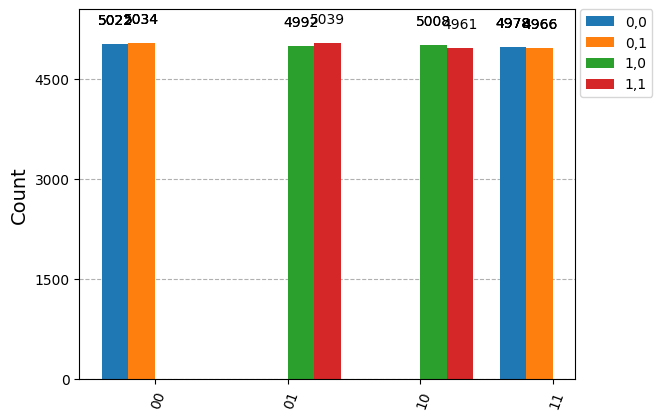

In [137]:
sequences = [(a, b) for a in [0, 1] for b in [0, 1]]
counts = []

for a, b in sequences:
    qc = build_circuit(a, b)

    sim = AerSimulator()
    result = sim.run(qc, shots=10000).result()
    counts.append(result.get_counts())

plot_histogram(counts, legend=[f'{a},{b}' for a, b in sequences])

# Execise 2:
Misterious circuit

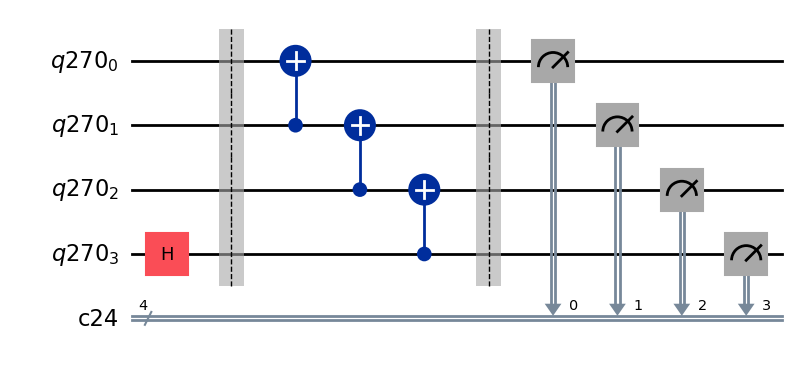

In [138]:
def build_circuit() -> QuantumCircuit:

    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)

    qc = QuantumCircuit(qr, cr)

    qc.h(3)

    qc.barrier()

    qc.cx(1, 0)
    qc.cx(2, 1)
    qc.cx(3, 2)

    qc.barrier()

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)
    qc.measure(3, 3)

    return qc

build_circuit().draw(output='mpl')

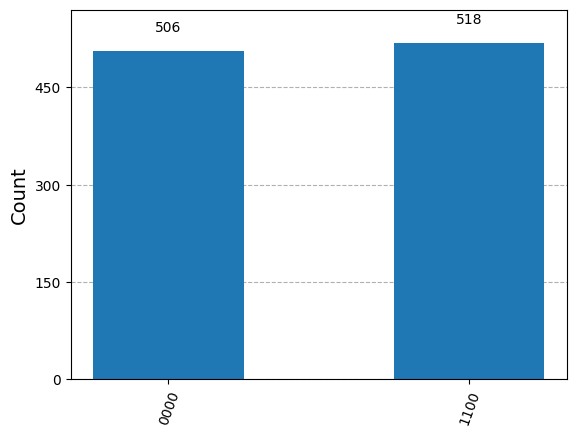

In [139]:
qc = build_circuit()

sim = AerSimulator(method='statevector')
result = sim.run(qc).result()

plot_histogram(result.get_counts())


# Deutsch-Jozsa Algorithm

## Balanced Algorithm

In [140]:
def balanced_3_qubit_oracle(qr:QuantumRegister, ancilla:QuantumCircuit) -> qiskit.circuit.Gate:

    qc = QuantumCircuit(qr, ancilla)

    qc.cx(0, ancilla)

    gate = qc.to_gate(label='Balanced Oracle')
    gate.name = 'Balanced Oracle'

    return gate

In [141]:
def DJ_balanced(n:int, init:list=None) -> QuantumCircuit:
    '''
    @param n: number of qubits
    @return: Deutsch-Josza algorithm circuit
    '''

    if init is not None:
        assert len(init) == n+1


    qr = QuantumRegister(n, name='q')
    ancilla = QuantumRegister(1, name='ancilla')
    cr = ClassicalRegister(n, name='c')

    qc = QuantumCircuit(qr, ancilla, cr)

    oracle = balanced_3_qubit_oracle(qr, ancilla)

    if init is None:
        for i in range(n):
            qc.initialize([1, 0], qr[i])
        
        qc.initialize([0, 1], ancilla)

    if init is not None:
        for i in range(n):
            qc.initialize(init[i], qr[i], normalize=True)
        
        qc.initialize(init[n], ancilla, normalize=True)

    for i in range(n):
        qc.h(i)
    
    qc.h(ancilla)

    qc.barrier()

    # append the custom oracle
    qc.append(oracle,range(n+1))

    qc.barrier()

    for i in range(n):
        qc.h(i)
    
    qc.barrier()

    for i in range(n):
        qc.measure(i, i)

    return qc

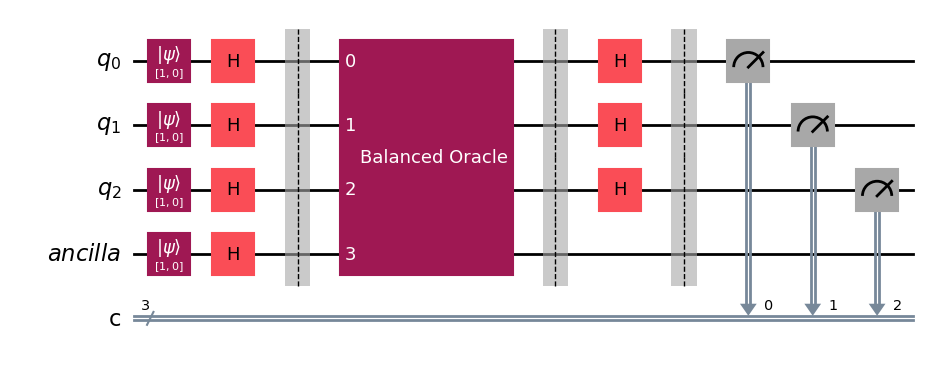

In [142]:
# Simulation
init = [[1, 0], [1, 0], [1, 0], [1, 0]]

qc = DJ_balanced(3, init=init)
qc.draw(output='mpl')

Single Input Simulation

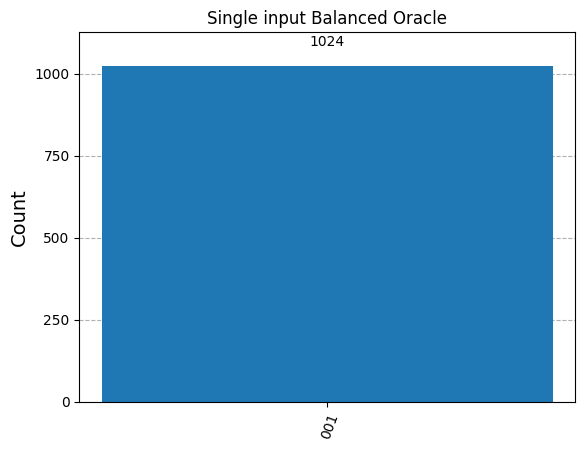

In [226]:
qc = DJ_balanced(3)

sim = AerSimulator(method='statevector')

qc = transpile(qc, sim)
result = sim.run(qc).result()

plot_histogram(result.get_counts(), title='Single input Balanced Oracle')

Multi input for Balance verification

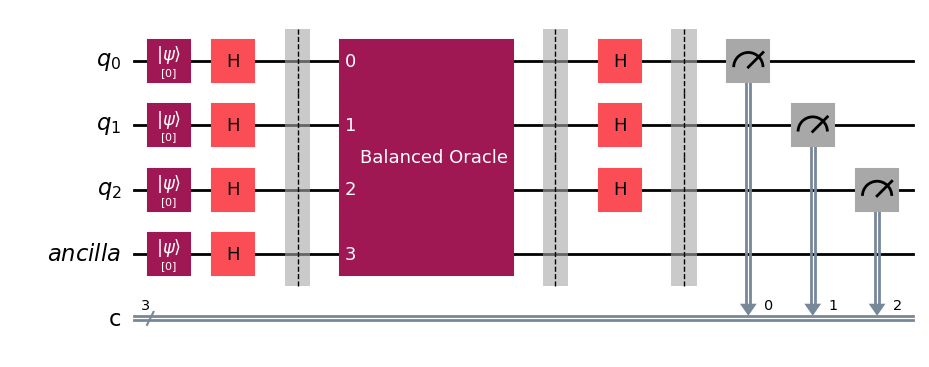

In [144]:
n = 4
inits = []
qcs = []

for i in range(2**n):
    init = bin(i)[2:].zfill(n)

    qr = QuantumRegister(n-1, name='q')
    ancilla = QuantumRegister(1, name='ancilla')
    cr = ClassicalRegister(n-1, name='c')

    qc = QuantumCircuit(qr, ancilla, cr)
    
    qc = DJ_balanced(n-1, init=init)

    qcs.append(qc)

qcs[0].draw(output='mpl')

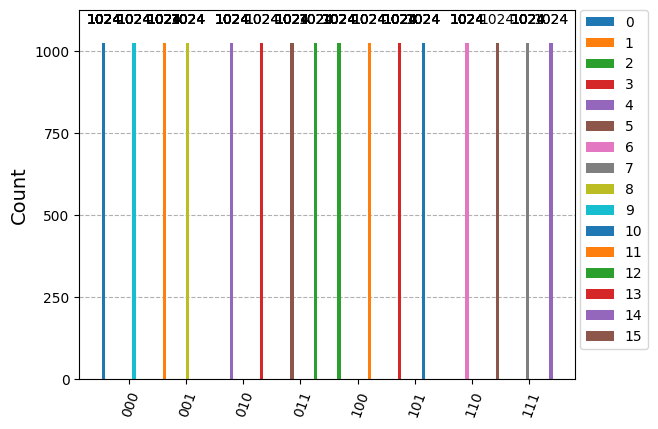

In [145]:
results = []
counts = []

for qc in qcs:
    sim = AerSimulator(method='statevector')
    qc = transpile(qc, sim)
    result = sim.run(qc).result()
    results.append(result)
    counts.append(result.get_counts())


# print(results[0].data)
plot_histogram(counts, legend=[f'{i}' for i in range(2**n)])

## Simulation on Real Backend

In [146]:
simulation = True

In [147]:
from qiskit_ibm_runtime import QiskitRuntimeService

if not simulation:
    service = QiskitRuntimeService('ibm_quantum')
    leas_busy = service.least_busy(operational=True, min_num_qubits=5)

    print(f'Least busy backend: {leas_busy}')

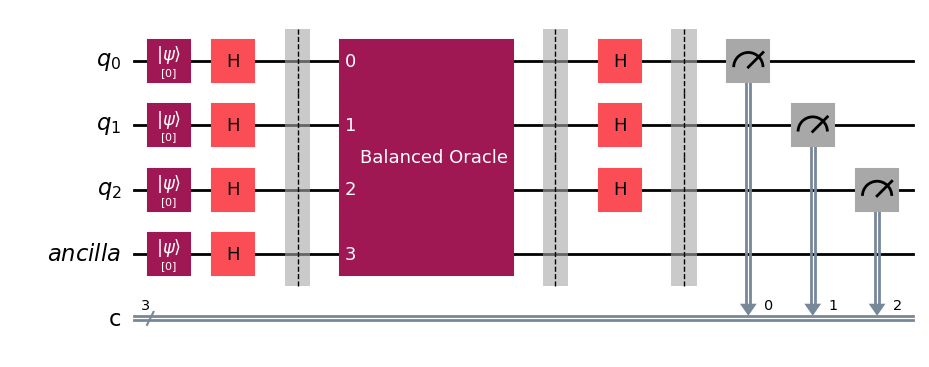

In [174]:
n = 4
inits = []
qcs = []

for i in range(2**n):
    init = bin(i)[2:].zfill(n)

    qr = QuantumRegister(n-1, name='q')
    ancilla = QuantumRegister(1, name='ancilla')
    cr = ClassicalRegister(n-1, name='c')

    qc = QuantumCircuit(qr, ancilla, cr)
    
    qc = DJ_balanced(n-1, init=init)

    qcs.append(qc)

qcs[0].draw(output='mpl')

### Transpile for real backend

In [175]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(optimization_level=3, backend=leas_busy)

qcs_trans = []
for qc in qcs:
    qcs_trans.append(pass_manager.run(qc))
# qcs_trans = pass_manager.run(qcs)

In [227]:
simulation = True

In [177]:
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

if not simulation:
    sampler = Sampler(mode=leas_busy)
    job = sampler.run(qcs_trans, shots=10000)


### Read results

In [210]:
job_id_0 = 'czghc2g7m0r0008vyn50'
job_id_1 = 'czgjtj2aejkg008cavgg'
job_id_2 = 'czgjyvkhrmy000842280'

counts_l = []
for jb in [job_id_0, job_id_1, job_id_2]:
    job = service.job(jb)
    result = job.result()
    single_counts = []
    for i in result:
        single_counts.append(i.data.c.get_counts())

    counts_l.append(single_counts)

## Results Balanced Oracle

In [264]:
labels = []
for i in range(2**n):
    labels.append(bin(i)[2:].zfill(n))

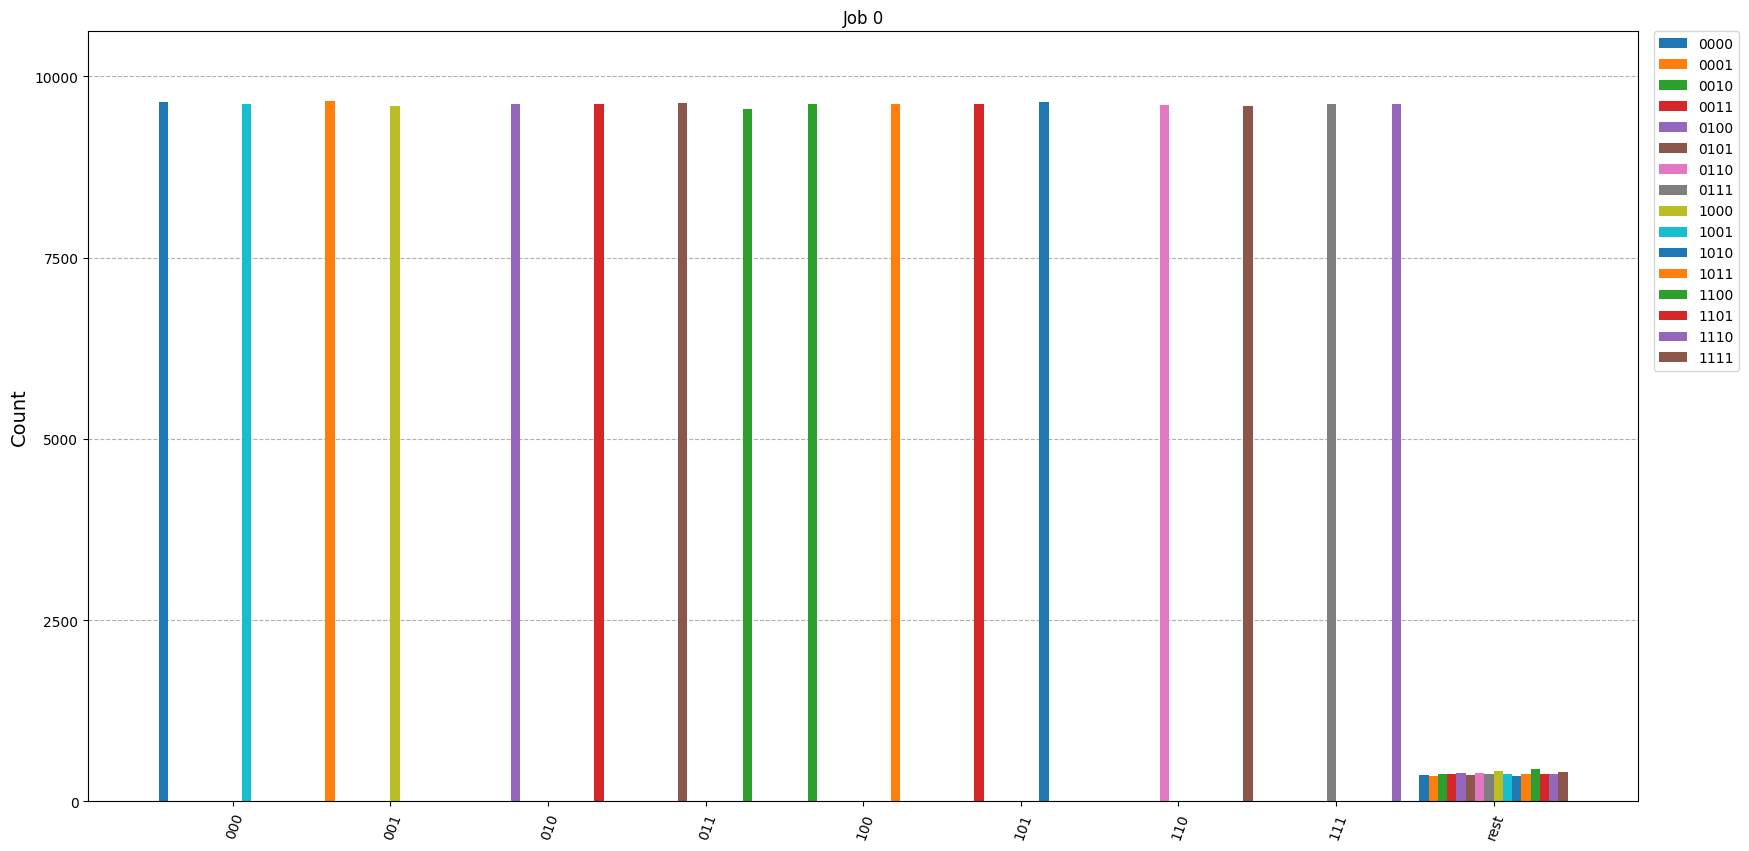

In [277]:
plot_histogram(counts_l[0], legend=labels, title='Job 0', figsize=(20, 10), bar_labels=False, number_to_keep=1)

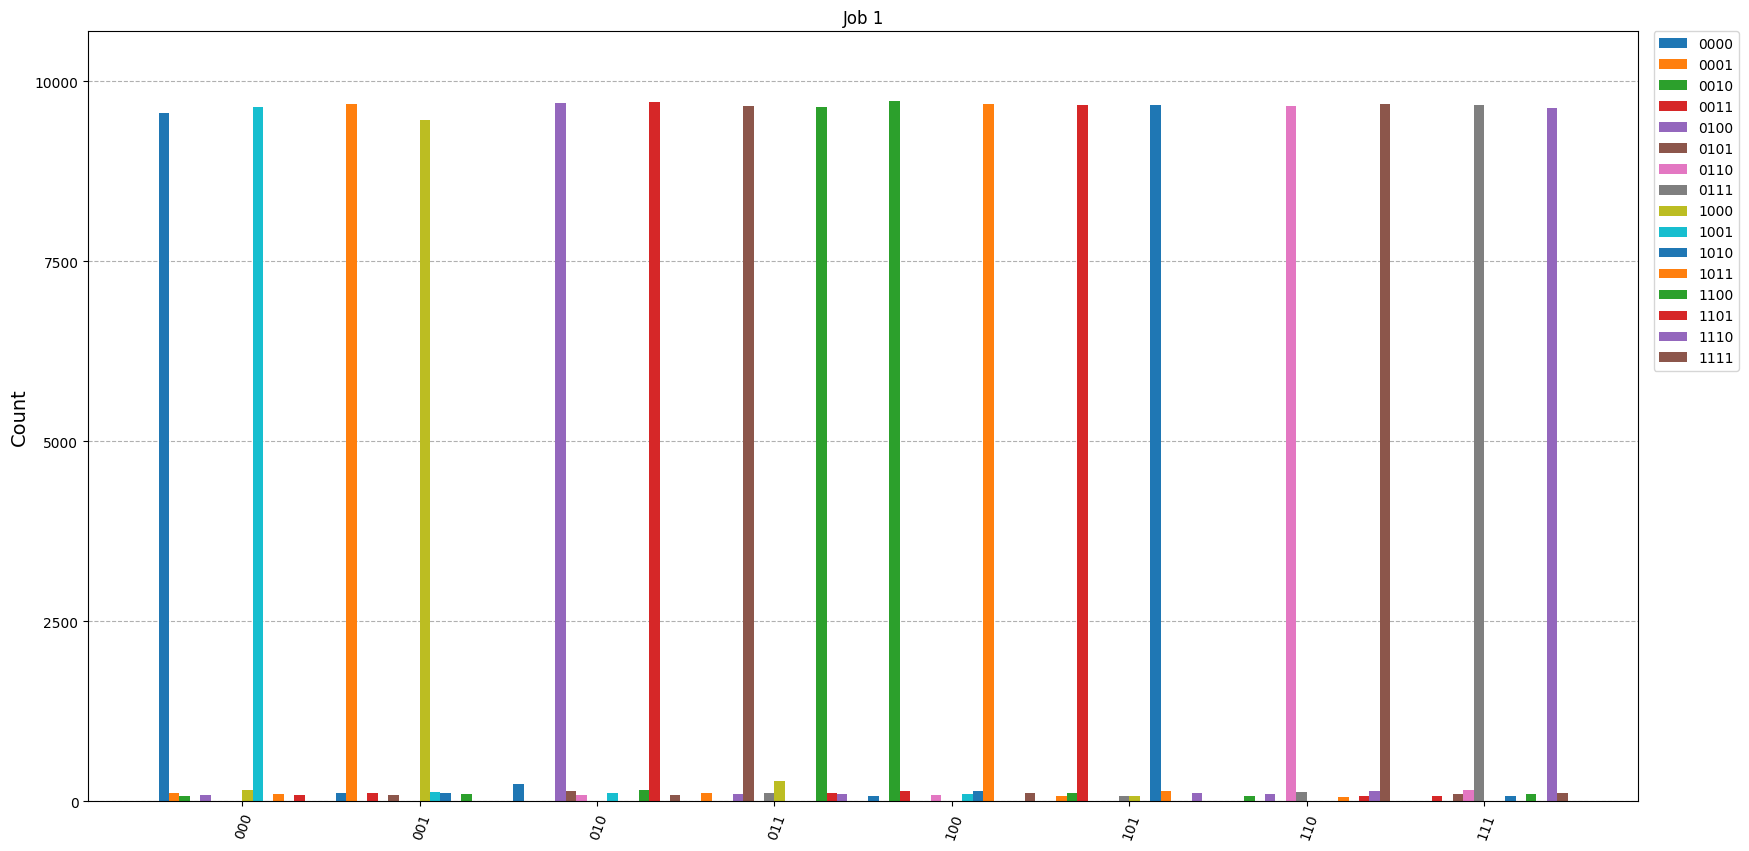

In [265]:
plot_histogram(counts_l[1], legend=labels, title='Job 1', figsize=(20, 10), bar_labels=False)

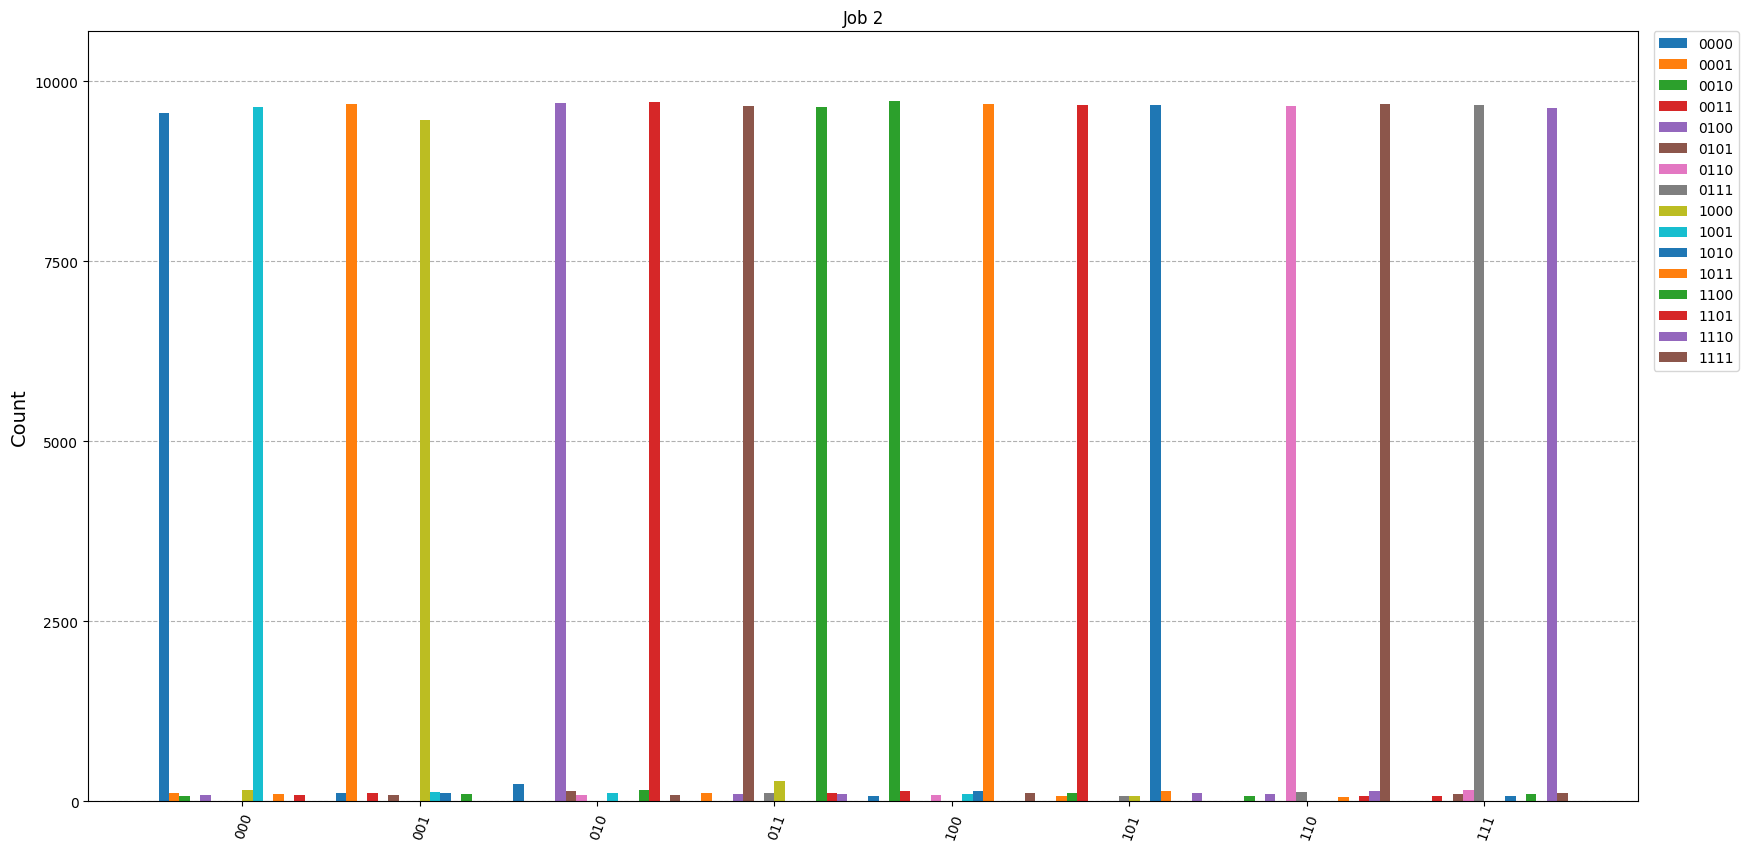

In [266]:
plot_histogram(counts_l[1], legend=labels, title='Job 2', figsize=(20, 10), bar_labels=False)

## alg